In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Opening data

In [53]:
class params:
    collab = False
    user = "Gabriel"
    local_data_path = "../data/"

In [54]:
if params.collab:
    from google.colab import drive
    drive.mount('/content/drive')
    if params.user == "Joanna":
      %cd /content/drive/MyDrive/CPB/
    elif params.user == "Gabriel":
      %cd /content/drive/MyDrive

In [76]:
if params.collab:
    from google.colab import auth
    auth.authenticate_user()

    import gspread
    from oauth2client.client import GoogleCredentials

    gc = gspread.authorize(GoogleCredentials.get_application_default())

    worksheets = []
    for k in range(5):
      # retrieve each spreadsheet
      worksheets.append(gc.open('Task_LeylaEmmaEtienne').get_worksheet(k))

    # the first row is the header
    # we fix the index so that it starts at 2, to be consistent with the annotations
    # we cast the timestamp on the int type

    tasks = []
    for sheet in worksheets:
        rows = sheet.get_all_values()
        columns = rows[0]
        columns[columns.index("Responding to (implicit)")] = "ImplicitResponse"
        columns[columns.index("Responding to (explicit)")] = "ExplicitResponse"
        task = pd.DataFrame.from_records(rows[1:], columns = columns, index=range(2, 1+len(rows))).astype({"TimeStamp" : int})
        tasks.append(task)

        
else:
    tasks = []
    columns = ['Participant', 'Message', 'TimeStamp', 'Tagging', 'ImplicitResponse',
               'ExplicitResponse', 'Calling']
    for k in [2, 1, 0, 3, 4]:
        task = pd.read_csv(params.local_data_path+"Annotated_"+str(k)+".csv", header=0, names=columns, usecols = list(range(7)))
        task = pd.DataFrame.from_records(task, index=range(2, 2+len(task))).astype({"TimeStamp" : int}).fillna("")
        tasks.append(task)
tasks[2]

Participant                                            Message  \
2      Pauline Stierlin                         On en discute ici ou quoi?   
3       Joanna Stierlin              oui uniquement sur cette conversation   
4      Antoine Commaret                                    d'accord cheffe   
5    Valentine Stierlin  arretez d'écrire !! je peux pas lire correctement   
6      Pauline Stierlin                            Quelqu'un a un indien ?   
..                  ...                                                ...   
113    Antoine Commaret  C'est moi je crois, pour moi il se réceptionne...   
114  Valentine Stierlin  ah bon mdr je savais pas qu'ils avaient cette ...   
115    Antoine Commaret                                C'est bon du coup !   
116  Valentine Stierlin                                         hallelujah   
117     Joanna Stierlin            vous pouvez m'écrire vos résultats svp?   

         TimeStamp Tagging ImplicitResponse ExplicitResponse Calling  
2    1610049678852                                                    
3    1610049712145                        2                           
4    1610049729016                        3                           
5    1610049739974                                                    
6    1610049751887                                                    
..             ...     ...              ...              ...     ...  
113  1610051174048                      111                           
114  1610051191889                      113                           
115  1610051204905                                                    
116  1610051215359                                                    
117  1610051230765                                                    

[116 rows x 7 columns]

In [56]:
IMPLICIT_KEYS = ["#DONTKNOW", "#SITUATION"]

# Data analysis

## Mean time between messages 

In [57]:
def mean_timing(df):
    # computing the time difference between the messages
    # df['deltaT'] = [0] + [(df['TimeStamp'][i+1] - df['TimeStamp'][i])/1000 for i in range(1, len(df['TimeStamp']))]
    # return np.mean(df['deltaT'])
    return (df.TimeStamp.max() - df.TimeStamp.min())/(1_000 * len(df))


for i, task in enumerate(tasks):
    print(f"Conversation {i} : {mean_timing(task):.2f}s on average")

Conversation 0 : 13.38s on average
Conversation 1 : 6.63s on average
Conversation 2 : 15.83s on average
Conversation 3 : 10.61s on average
Conversation 4 : 12.51s on average


### Kalman's model

In [58]:
def response_times(df):
    Delta_ts = []

    for index, row in df.iterrows():

        if row.ExplicitResponse:
            ind = row.ExplicitResponse
        elif row.ImplicitResponse and row.ImplicitResponse not in IMPLICIT_KEYS:
            ind = row.ImplicitResponse
        else:
            continue

        ind = int(ind)

        delta_t = row.TimeStamp - df.TimeStamp.loc[ind]
        Delta_ts.append(delta_t)

    return Delta_ts

In [59]:
def distribution(X, delta =200):
    # Compute the underlying distribution of the samples given by X
    # approximated as a discrete distribution, with step *delta*


    m = int(min(X)//delta)
    M = int(max(X)//delta)

    Count = np.zeros(M-m + 1)
    for x in X:
        i = int(x//delta - m)
        Count[i] += 1

    Valeur = np.arange(m*delta, M*delta + delta, delta)
    return Valeur, Count

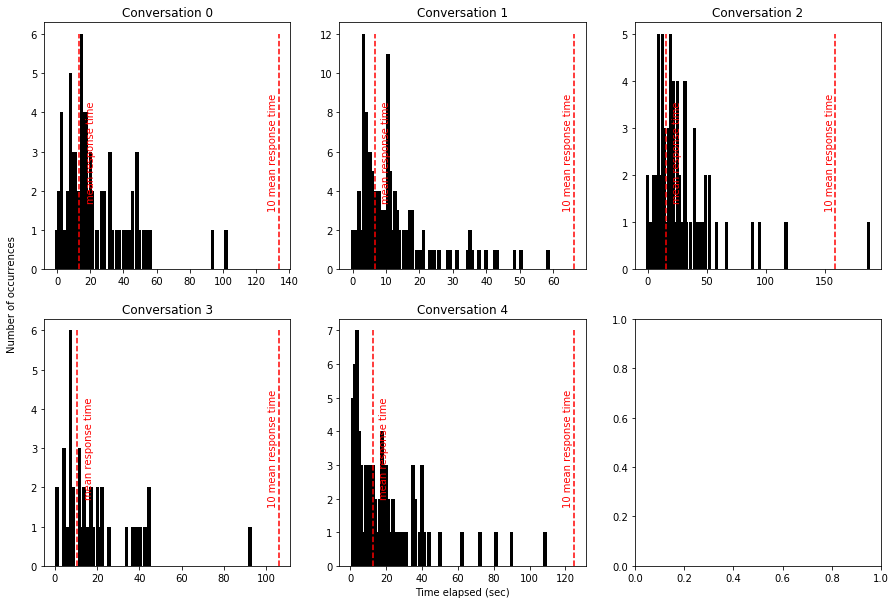

In [60]:
fig, axs = plt.subplots(2, 3, figsize = (15, 10))

All_Ts = []

for k, task in enumerate(tasks):
    Ts = response_times(task)
    All_Ts += Ts
    i,j = k//3, k%3

    mean = mean_timing(task)
    delta = int((1000*mean / 10) // 0.1 * 0.1)
    valeur, count = distribution(Ts, delta = delta)


    axs[i,j].plot([mean, mean], [0, count.max()], "r--" )
    axs[i,j].plot([10*mean, 10*mean], [0, count.max()], "r--" )
    axs[i,j].text(mean * 1.3, count.max()/2, "mean response time", rotation = "vertical", color = "red", va='center')
    axs[i,j].text(mean * 9.5, count.max()/2, "10 mean response time", rotation = "vertical", color = "red", va='center')

    axs[i,j].bar(valeur/1000, count, color="black", width = delta/600)




    axs[i,j].set_title(f"Conversation {k}")

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel("Time elapsed (sec)")
plt.ylabel("Number of occurrences")
plt.savefig(params.local_data_path + "Kalman_indiv.png")
plt.show()

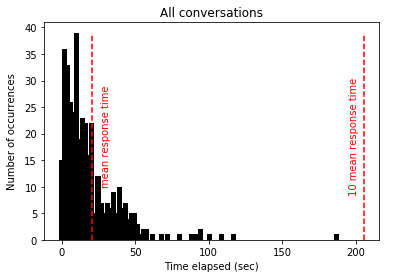

In [61]:
mean = sum(All_Ts)/len(All_Ts)/1_000
delta = int((1000*mean / 10) // 0.1 * 0.1)
valeur, count = distribution(All_Ts, delta = delta)

fig, ax = plt.subplots()
ax.plot([mean, mean], [0, count.max()], "r--" )
ax.plot([10*mean, 10*mean], [0, count.max()], "r--" )
ax.text(mean * 1.3, count.max()/2, "mean response time", rotation = "vertical", color = "red", va='center')
ax.text(mean * 9.5, count.max()/2, "10 mean response time", rotation = "vertical", color = "red", va='center')

ax.bar(valeur/1000, count, color="black", width = delta/600)




ax.set_title(f"All conversations")

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel("Time elapsed (sec)")
plt.ylabel("Number of occurrences")
plt.savefig(params.local_data_path + "Kalman_whole.png")
plt.show()

### Explicit vs implicit timing

In [68]:
def implicit_response_times(df):
    Delta_ts = []

    for index, row in df.iterrows():
        if row.ImplicitResponse and row.ImplicitResponse not in IMPLICIT_KEYS:
            ind = row.ImplicitResponse
        else:
            continue

    ind = int(ind)

    delta_t = row.TimeStamp - df.TimeStamp.loc[ind]
    Delta_ts.append(delta_t)

    return Delta_ts

def explicit_response_times(df):
    Delta_ts = []

    for index, row in df.iterrows():

        if row.ExplicitResponse:
            ind = row.ExplicitResponse
        else:
            continue

        ind = int(ind)

        delta_t = row.TimeStamp - df.TimeStamp.loc[ind]
        Delta_ts.append(delta_t)

    return Delta_ts

No handles with labels found to put in legend.
No handles with labels found to put in legend.


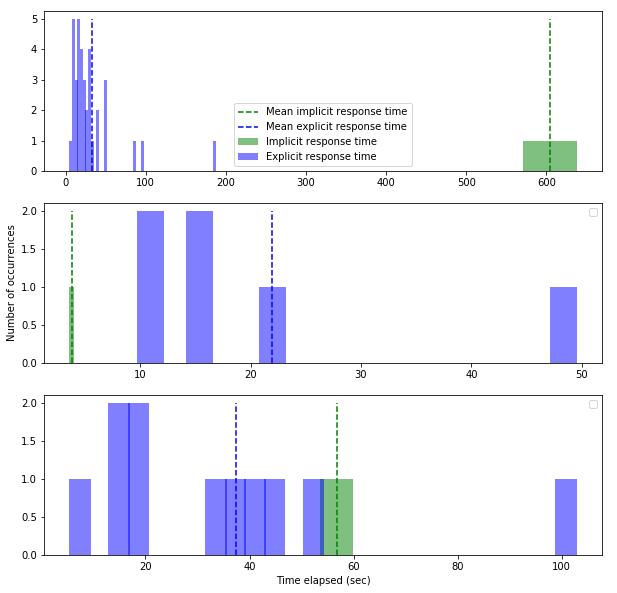

In [90]:
# two conversations are removed for having only respectively one explicit response and 0 explicit response

fig, axs = plt.subplots(3, 1, figsize = (10, 10))
for k, task in enumerate(tasks[:3]):
    imp_Ts = implicit_response_times(task)
    exp_Ts = explicit_response_times(task)

    imp_mean = sum(imp_Ts)/len(imp_Ts)/1_000
    exp_mean = sum(exp_Ts)/len(exp_Ts)/1_000

    imp_delta = int(1_000 * imp_mean / 10 // 0.1 * 0.1)
    exp_delta = int(1_000 * exp_mean / 10 // 0.1 * 0.1)

    imp_values, imp_count = distribution(imp_Ts, delta = imp_delta)
    exp_values, exp_count = distribution(exp_Ts, delta = exp_delta)


    height = max(max(imp_count), max(exp_count))
    axs[k].plot([imp_mean, imp_mean], [0, height], "g--", label = "Mean implicit response time" if k==0 else None)
    axs[k].plot([exp_mean, exp_mean], [0, height], "b--", label = "Mean explicit response time" if k==0 else None)

    axs[k].bar(imp_values/1_000, imp_count, color="green", width = imp_delta/900, alpha = 0.5, label = "Implicit response time" if k==0 else None)
    axs[k].bar(exp_values/1_000, exp_count, color="blue", width = exp_delta/900, alpha = 0.5, label = "Explicit response time" if k==0 else None)
    axs[k].legend()

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel("Time elapsed (sec)")
plt.ylabel("Number of occurrences")

plt.show()

## Calling a participant

### Calling answers or elicit an answer

In [79]:
def call_answers(df, msg_id):
  msg = df.loc[msg_id]
  called_names = msg.Calling.split(',')

  participants = list(set(df.Participant))
  name_to_participant = {p.split()[0] : p for p in participants}
  names = [name_to_participant[called_name] for called_name in called_names]

  A = (df.ImplicitResponse == str(msg_id))
  B = (df.ExplicitResponse == str(msg_id))
  Responses = df[A | B]
  CalledResponses = Responses[Responses.Participant.isin(names)]
  UncalledResponses = Responses[~Responses.Participant.isin(names)]
  return CalledResponses, UncalledResponses

def call_is_answering(df, msg_id):
  msg = df.loc[msg_id]
  if not msg.ImplicitResponse or msg.ImplicitResponse in IMPLICIT_KEYS:
    return False
  beingAnswered = df.loc[int(msg.ImplicitResponse)]
  return beingAnswered.Participant.split()[0] == msg.Calling


In [80]:
PRONOUNS = ["1ST_SNG", "2ND_SNG", "3RD_SNG", "1ST_PLR", "2ND_PLR", "3RD_PLR"]

def typeOfCall(df, msg_id, msg):
  if not msg.Calling or msg.Calling in PRONOUNS:
    return "NotACall"
  if call_is_answering(df, msg_id):
    return "Answering"
  else:
    Called, Uncalled = call_answers(df, msg_id)
    if len(Called):
      return "Calling"
    return "UnansweredCalling"

In [81]:
CallStats = {"NotACall" : 0, "Answering" : 0, "Calling" : 0, "UnansweredCalling" : 0}

for task in tasks:
  for index, row in task.iterrows():
    CallStats[typeOfCall(task, index, row)] += 1

print(CallStats)

# We correct by hand two false positive where one message is answering a msg that comes before the data
# and one message is answered after the collected data
CallStats["UnansweredCalling"] += -2 
CallStats["Answering"] += 1
CallStats["Calling"] += 1

{'NotACall': 524, 'Answering': 11, 'Calling': 9, 'UnansweredCalling': 13}


In [82]:
tot = sum([value for key, value in CallStats.items() if key != "NotACall"])
for key, value in CallStats.items():
  if key != "NotACall":
    print(f"{100*value/tot:.1f}% of {key}")

36.4% of Answering
30.3% of Calling
33.3% of UnansweredCalling


## Adding a *response type* annotation to the data

In [83]:
def typeOfResponse(df, msg_id, msg):
  if msg.ExplicitResponse:
    return "Explicit"
  if not msg.ImplicitResponse or msg.ImplicitResponse in IMPLICIT_KEYS:
    return "NotAResponse"
  if typeOfCall(df, msg_id, msg) == "Answering":
    return "WithCall"
  return "Implicit"

In [84]:
for task in tasks:
  for index, row in task.iterrows():
    task.at[index, "TypeOfResponse"] = typeOfResponse(task, index, row)

### And now we can make some response stats

In [85]:
def response_times(df, responsetype = None):
  Delta_ts = []

  for index, row in df.iterrows():

    if responsetype is None:
      if row.ExplicitResponse:
        ind = row.ExplicitResponse
      elif row.ImplicitResponse and row.ImplicitResponse not in IMPLICIT_KEYS:
        ind = row.ImplicitResponse
      else:
        continue

      ind = int(ind)

      delta_t = row.TimeStamp - df.TimeStamp.loc[ind]
      Delta_ts.append(delta_t)
    
    elif responsetype == row.TypeOfResponse:
      ind = row.ExplicitResponse if responsetype == "Explicit" else row.ImplicitResponse
      ind = int(ind)
      delta_t = row.TimeStamp - df.TimeStamp.loc[ind]
      Delta_ts.append(delta_t)

  return Delta_ts

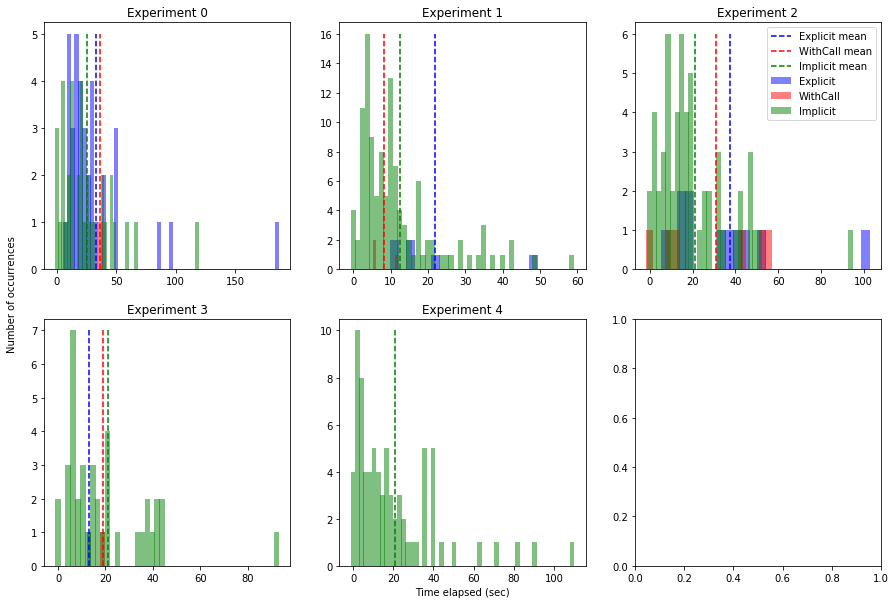

In [88]:
fig, axs = plt.subplots(2, 3, figsize = (15, 10))

COLOURS = ["blue", "red", "green"]

All_Ts = [[], [], []]

for k, task in enumerate(tasks):
  i,j = k//3, k%3
  axs[i,j].set_title(f"Experiment {k}")

  height = 0

  for c, typ in enumerate(["Explicit", "WithCall", "Implicit"]):
    Ts = response_times(task, typ)
    if len(Ts) == 0:
      continue
    mean = sum(Ts)/len(Ts)/1_000
    delta = int(1_000 * mean / 10 // 0.1 * 0.1)
    values, count = distribution(Ts, delta = delta)
    height = max(height, max(count))

    axs[i,j].bar(values/1_000, count, color = COLOURS[c], width = delta / 900, alpha = 0.5, label = f"{typ}")

    All_Ts[c] += Ts

  for c, typ in enumerate(["Explicit", "WithCall", "Implicit"]):
    Ts = response_times(task, typ)
    if len(Ts)==0:
      continue
    mean = sum(Ts)/len(Ts)/1_000
    axs[i,j].plot([mean, mean], [0, height], color = COLOURS[c], linestyle = "--", label = f"{typ} mean")
  
  if k==2:
    axs[i,j].legend()


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel("Time elapsed (sec)")
plt.ylabel("Number of occurrences")

plt.show()

[]

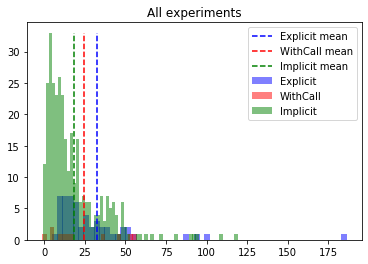

In [92]:
plt.title("All experiments")
height = 0
for c, typ in enumerate(["Explicit", "WithCall", "Implicit"]):
  Ts = All_Ts[c]
  mean = sum(Ts)/len(Ts)/1_000
  delta = int(1_000 * mean / 10 // 0.1 * 0.1)
  values, count = distribution(Ts, delta = delta)
  height = max(height, max(count))
  
  plt.bar(values/1_000, count, color = COLOURS[c], width = delta / 900, alpha = 0.5, label = f"{typ}")

for c, typ in enumerate(["Explicit", "WithCall", "Implicit"]):
  Ts = All_Ts[c]
  mean = sum(Ts)/len(Ts)/1_000
  plt.plot([mean, mean], [0, height], color = COLOURS[c], linestyle = "--", label = f"{typ} mean")

plt.legend()
plt.savefig(params.local_data_path + "withcall_whole.png")
plt.plot()

# Lexical analysis

In [166]:
!pip install fuzzywuzzy

In [175]:
from fuzzywuzzy import fuzz, process  # string similarity processing package

In [177]:
s1 = "Moi aussi"
s2 = "alors moi aussi"
s = [s1]
s.append("Normalement")
s.append("Moi aussi")
s.append("att j'ai 0 en commun juste avec toi etienne?")
s.append("si, le mec assis tout simplement")
s.append("ok")
s.append("Tadaaa")
s.append("le dernier personnage que j’ai c’est quelqu’un qui se penche en avant")


print(fuzz.ratio(s1, s2))
print(fuzz.partial_ratio(s1, s2))
print(fuzz.token_sort_ratio(s1, s2))
print(fuzz.token_set_ratio(s1, s2))
print(process.extractOne(s2, s))

67
89
75
100
('Moi aussi', 90)


In [238]:
for task in tasks:
  for index, row in task.iterrows():
    if row.TypeOfResponse  == "Implicit":
      msg1 = row.Message
      msg2 = task.loc[int(row.ImplicitResponse)].Message
      task.at[index, "FuzzyScore"] = (fuzz.ratio(msg1, msg2) + fuzz.partial_ratio(msg1, msg2))//2
      

In [242]:
def response_times(df, conditional = None):
  Delta_ts = []

  for index, row in (df if conditional is None else df[conditional]).iterrows():

    if row.ExplicitResponse:
      ind = row.ExplicitResponse
    elif row.ImplicitResponse and row.ImplicitResponse not in IMPLICIT_KEYS:
      ind = row.ImplicitResponse
    else:
      continue

    ind = int(ind)

    delta_t = row.TimeStamp - df.TimeStamp.loc[ind]
    Delta_ts.append(delta_t)
  
  return Delta_ts

def response_length(df, conditional = None):
  Delta_ts = []

  for index, row in (df if conditional is None else df[conditional]).iterrows():

    if row.ExplicitResponse:
      ind = row.ExplicitResponse
    elif row.ImplicitResponse and row.ImplicitResponse not in IMPLICIT_KEYS:
      ind = row.ImplicitResponse
    else:
      continue

    ind = int(ind)

    delta_t = index-ind
    Delta_ts.append(delta_t)
  
  return Delta_ts

In [246]:
def PearsonCorrelation(X, Y):
  X_bar = sum(X)/len(X)
  Y_bar = sum(Y)/len(Y)
  return ((X - X_bar)*(Y - Y_bar)).sum() / np.sqrt((X - X_bar)**2 * (Y - Y_bar)**2).sum()

0.25627629589101486


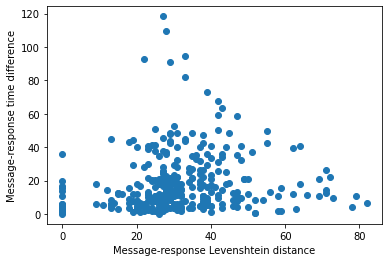

In [250]:
score_to_time = []
for task in tasks:
  fuzzy_scores = list(task.FuzzyScore[task.FuzzyScore.notnull()])
  delta_ts = response_times(task, task.FuzzyScore.notnull())
  delta_ls = response_length(task, task.FuzzyScore.notnull())

  score_to_time += zip(fuzzy_scores, delta_ts)

X, Y = zip(*score_to_time)
X, Y = np.array(X), np.array(Y)
plt.scatter(X, Y/1000)
print(PearsonCorrelation(X, Y))
plt.xlabel("Message-response Levenshtein distance")
plt.ylabel("Message-response time difference")
plt.show()